# Creating Uniform Voltage Data
Before we start working on our voltage data, we have to convert it into a uniform format.  

## Table of Contents
* [Converting Dataverse Voltage Data](#dataverse-voltage)

## Voltage Data Formats
The two main data sources in this project are the current operating ESMI station data, which is scraped from the Prayas ESMI website using the india_esmi_scraper.py scraper, as well as the Harvard Dataverse Data **(link?)**.  
The two are formatted differently.  
The Harvard Dataverse Data is formatted in a 60 x n grid, with each row being labelled with an hour in the day, from 0-23, and each of the columns being a minute of the hour from 0-59.  
The scraped data is formatted in two columns, with the time column being the datetime down to the minute, and the voltage column being the voltage from 0-255.  

I will be converting the dataverse data into the scraped data format.

## ESMI and Harvard Dataverse ID
In addition to having different data formats, the two data sources also use different numbering systems.  
Harvard Dataverse uses the names of the 528 stations covered in the time period of the dataset, between 2014-2018.  
The ESMI scraper uses the ESMI ids assigned in the dropdown elements used by the web scraper to select stations on the Prayas website.  

The India station locations were all cross-referenced **(still need to document this)**, with duplicates and stations outside of the ERA5 dataset removed. Each of the newly-scraped ESMI stations was given an ID number proceeding 528 (the last number assigned to the Dataverse stations), with duplicates in the Dataverse data removed.  

After this process, we have ids from 1-572 (with some missing because duplicates were removed), and a uniform data format.

These files will all be stored in the india_processing/india_uniform directory, and their IDs can be referenced in the file *ESMI_India_538_locations.csv*.

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import shutil
from datetime import datetime, timedelta
import numpy as np
import math

## Converting Dataverse Voltage Data <a class="anchor" id="dataverse-voltage"></a>
We first need to verify that all of the stations deemed to be in the ERA5 dataset's range is in either the Dataverse dataset or the ESMI dataset.

In [3]:
def strip_name(name, exceptions = None):
    formatted = name.split('-')[0].split('[')[0].strip()
    
    if exceptions:
        return exceptions(formatted) # run the name through the entered exceptions function, if provided
    else:
        return formatted

In [4]:
# Import the location information table, which we can use to map between station_id, ESMI_ID, and station names.
locations_path = "../ESMI_India_538_locations.csv"
locations = pd.read_csv(locations_path, dtype={"ESMI_ID" : str, "station_id" : int}, usecols=["station_id", "ESMI_ID", "Location name", "District", "State", "Lat", "Lon"])
locations.rename(columns={"Location name": "station_name", "District" : "district", "State": "state", "Lat": "lat", "Lon": "lon"}, inplace=True)
locations["station_name"] = locations["station_name"].apply(strip_name)

In [67]:
# Get the unique names from all of the Harvard Dataverse spreadsheets
dataverse_dir = "../india_dataverse"
stations_found = set()
for file in os.listdir(dataverse_dir):
    if file.endswith('.csv'):
        data = pd.read_csv(os.path.join(dataverse_dir, file))
        stations_found.update(data["Location name"].unique())

stations_found = set([strip_name(x) for x in stations_found])

C:\Users\nytig\AppData\Local\Temp\ipykernel_7444\557091671.py:6: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(dataverse_dir, file))
C:\Users\nytig\AppData\Local\Temp\ipykernel_7444\557091671.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(dataverse_dir, file))


In [68]:
# Add all of the station ids to a set to be checked against the available names/ids in either dataset
station_names = set(locations["station_name"])

# Update, checking off all the names found in the dataverse name field
stations_remaining = station_names.difference(stations_found)
print(stations_remaining)
len(stations_remaining)

{'Datalpara', 'Kardaitola', 'GNB road', 'Ulubari', 'Mihijam', 'Banjara Hills', 'Chanho', 'Borbheta', 'Dudhimati', 'Haider Nagar', 'Domadih', 'Rajdhani Masjid', 'Gohaibari', 'Tarun Nagar', 'Kothrud', 'Bilasipara', 'Lalmatia', 'Bamunimaidan', 'Bhurkunda', 'Besant Nagar', 'Kolebira', 'Zalim Khurd', 'Chouparan', 'Saheed Nagar', 'Nagaon', 'Ameerpet', 'Sahakar Nagar', 'Netarhat', 'Mahuadanr', 'Guwahati Club', 'Alipur', 'Vidya Nagar', 'ASEB Campus', 'Deopur', 'Perka', 'Tezpur', 'Khatorbari', 'Kairo', 'Nichinta', 'Capital Electrical Subdivision', 'Hedayetpur', 'Amrit Nagar', 'Satbarwa', 'Kapoorthla', 'Juri Par Shanti Path'}


45

In [69]:
# Get the station_ids of the stations still unaccounted for after the dataverse data
station_ids_remaining = set(locations[(locations['station_name'].isin(stations_remaining))]['station_id'])

In [70]:
# Print all of the station names that we haven't found but expected to, ids less than 529, because those we expect to find in 
for id in station_ids_remaining:
    if int(id) < 529:
        print(locations[locations['station_id'] == id]['station_name'].values[0])

print(stations_found.difference(station_names))

157    Hedayetpur
Name: station_name, dtype: object
85    Capital Electrical Subdivision
Name: station_name, dtype: object
45    Bamunimaidan
Name: station_name, dtype: object
137    GNB road
Name: station_name, dtype: object
459    Vidya Nagar
Name: station_name, dtype: object
449    Ulubari
Name: station_name, dtype: object
197    Juri Par Shanti Path
Name: station_name, dtype: object
26    ASEB Campus
Name: station_name, dtype: object
436    Tarun Nagar
Name: station_name, dtype: object
149    Guwahati Club
Name: station_name, dtype: object
139    Gohaibari
Name: station_name, dtype: object
113    Datalpara
Name: station_name, dtype: object
{'KT_4355', 'Zhirad', 'Capital Electrical Subdivision Guwahati', 'GNB road Guwahati', 'Karnataka_7', 'Dehradun_5', 'Sahakarnagar', 'Guwahati Club Guwahati', 'Betalbatim', 'Benaulim', 'Ameerpeth', 'Tilak Ali Ratnagiri', 'Gimhavne', 'Nepal _8193', 'Colva', 'Subhash road Ratnagiri', 'Faridabad_1', 'Sancole', 'Santacruz', 'Banjara hills Hyderabad', '

In [5]:
# Function to deal with exceptions in name formatting
def name_exceptions(name):
    if name == "VidyaNagar":
        return "Vidya Nagar"
    if "Guwahati" in name: # Remove Guwahati from the end
        return " ".join(name.split(" ")[:-1])
    return name

In [72]:
stations_found = set([strip_name(x, name_exceptions) for x in stations_found])
stations_remaining = station_names.difference(stations_found)

station_ids_remaining = set(locations[(locations['station_name'].isin(stations_remaining))]['station_id'])

for id in station_ids_remaining:
    if int(id) < 529:
        print(locations[locations['station_id'] == id]['station_name'])

In [84]:
esmi_dir = "../india_esmi"

esmi_found = set() # set for the esmi_ids found
for file in os.listdir(esmi_dir):
    if file.endswith('.csv'):
        esmi_found.add(file.split('+')[0])

ids_found = set(locations[locations['ESMI_ID'].isin(esmi_found)]['station_id'])

In [85]:
final_remaining = station_ids_remaining.difference(ids_found)
print(final_remaining)

set()


Now that we have confirmed that all of the expected stations are present, we can move on to converting the data into the uniform format.  
First, we can simply rename the ESMI stations according to their uniform station id.

In [6]:
uniform_dir = "../india_processing/india_uniform"

In [ ]:
for file in os.listdir(esmi_dir):
    if file.endswith('.csv'):
        esmi_id = file.split('+')[0]
        uniform_id = locations[locations['ESMI_ID'] == esmi_id]['station_id'].values[0]

        shutil.copy(os.path.join(esmi_dir, file), os.path.join(uniform_dir, f'station_{uniform_id}.csv'))

Then, we convert the Dataverse format into our uniform format.  
This involves taking each of the individual rows, taking the date and hour columns, along with the index of the minutes columns and transforming that into a vertical 2xn of datetime, voltage values, which can be concatenated together.  

Then we will use our existing name parsing to section each of the sheets by station.  
After this has been done for every station, we can save it to our uniform data location, taking care not to override any existing sheets, as the stations which are duplicate between ESMI and Dataverse, ESMI takes priority.

Also, as we discovered later in the Cleanup section, the 2019Jan_Jun.csv has data quality problems which have to be address before we can incorporate it into our uniform dataset.

In [8]:
dataverse_dir = "../india_dataverse/"

# Filter out just the locations that aren't actively scraped ESMI locations, so we avoid mapping them to a location number when processing dataverse data.
rem_locations = locations[pd.isna(locations['ESMI_ID'])]
name_to_station_id = dict(zip(rem_locations['station_name'].to_list(), rem_locations['station_id'].to_list())) # Create dictionary to make id lookup more efficient

In [ ]:

for file in os.listdir(dataverse_dir):
    if "2019" in file: # Skip 2019 for now
        continue
    print(file)
    hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)

    # Remove the weird excel export #VALUE! artifacts
    hd_df.replace('#VALUE!', pd.NA, inplace=True)
    hd_df.dropna(inplace=True)
    hd_df.iloc[:, -60:] = hd_df.iloc[:, -60:].apply(pd.to_numeric)

    # Merge the date and hour columns to create a pd datetime
    if '/' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%m/%d/%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    elif '-' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%d-%m-%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    else:
        print('Invalid date format')
        break
        
    hd_df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Derive the uniform station_id from the station names
    hd_df.rename(columns={'Location name': 'station_name'}, inplace=True)
    
    # Create a new column of uniform station_ids, assigning -1 if it is a station we have already discarded, so we can ignore it
    hd_df.insert(loc=0, column='station_id', value=hd_df['station_name'].apply(lambda x : name_to_station_id.get(strip_name(x, exceptions=name_exceptions), -1)))
    hd_df.drop('station_name', axis=1, inplace=True)
    
    unpivoted_rows = []
    for index in tqdm(range(hd_df.shape[0])):
        if hd_df.iloc[index, 0] == -1: # Skip irrelevant or already covered stations
            continue
            
        unpivoted_row = hd_df.iloc[[index], :].melt(id_vars=['station_id', 'time'], ignore_index=True)
        unpivoted_row['time'] = unpivoted_row['time'] + pd.to_timedelta(unpivoted_row['variable'].apply(lambda x : int(x.split(' ')[1])), unit='m')
        
        unpivoted_rows.append(unpivoted_row)
    
    unpivoted_df = pd.concat(unpivoted_rows)
    unpivoted_df.drop('variable', axis=1, inplace=True)
    unpivoted_df.rename(columns={'value': 'voltage'}, inplace=True)

    # If the station_data already exists, append the new data on the end, otherwise, write directly to a new csv
    for station_id in unpivoted_df['station_id'].unique():
        output_path = os.path.join(uniform_dir, f'station_{station_id}.csv')
        subset_df = unpivoted_df[unpivoted_df['station_id'] == station_id]
        subset_df = subset_df.drop('station_id', axis=1)
        
        if os.path.exists(output_path):
            station_df = pd.read_csv(output_path, header=0, parse_dates=['time'])
            if station_df['time'].iloc[-1] < subset_df['time'].iloc[0]:
                station_df = pd.concat((station_df, subset_df))
                station_df.to_csv(output_path, index=False)
        else:
            subset_df.to_csv(output_path, index=False)
    

## Dealing with 2019Jan-Jun
Because there are the presence of duplicate rows, both duplicate in the timestamp and station.
I will just remove these duplicate rows.

There is also the issue of erroneous voltage values, such as voltages of 535 or 999, which do not appear elsewhere in the dataverse dataset. I choose to simply ignore rows which contain values greater than 400 entirely, because in the way that we aggregate voltage data over hours or days, removal of a single datapoints is equivalent to removal of the entire hour anyways.

We also take special care to simply remove the data of Bodireddypally-Prakasam and Kanheri Sarap, as the repeat rate is very high, and what can be salvaged may be questionable.

In [20]:
for file in os.listdir(dataverse_dir):
    if not "2019" in file: # Only operate on the 2019 dataset
        continue
    print(file)
    hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)

    # Remove the weird excel export #VALUE! artifacts
    hd_df.replace('#VALUE!', pd.NA, inplace=True)
    hd_df.dropna(inplace=True)
    hd_df.iloc[:, -60:] = hd_df.iloc[:, -60:].apply(pd.to_numeric)
    hd_df.iloc[:, -60:][hd_df.iloc[:, -60:] > 400] = pd.NA
    hd_df.dropna(inplace=True) # Ignore rows with values greater than 400 

    # Merge the date and hour columns to create a pd datetime
    if '/' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%m/%d/%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    elif '-' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%d-%m-%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    else:
        print('Invalid date format')
        break
        
    hd_df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Derive the uniform station_id from the station names
    hd_df.rename(columns={'Location name': 'station_name'}, inplace=True)
    
    # Create a new column of uniform station_ids, assigning -1 if it is a station we have already discarded, so we can ignore it
    hd_df.insert(loc=0, column='station_id', value=hd_df['station_name'].apply(lambda x : name_to_station_id.get(strip_name(x, exceptions=name_exceptions), -1)))
    hd_df.drop('station_name', axis=1, inplace=True)

    hd_df = hd_df[hd_df['station_id'] != -1]
    hd_df = hd_df[hd_df['station_id'] != 223]
    hd_df = hd_df[hd_df['station_id'] != 86] # Remove all the high error rate and irrelevant stations

    station_ids = hd_df['station_id'].unique()
    
    stations_2019 = {}
    for station_id in station_ids:
        print(station_id)
        unpivoted_rows = []
        station_df = hd_df[hd_df['station_id'] == station_id]

        station_df = station_df[~station_df.duplicated(subset=['time'], keep=False)] # Remove duplicate times

        for index in tqdm(range(station_df.shape[0])):
            unpivoted_row = station_df.iloc[[index], :].melt(id_vars=['station_id', 'time'], ignore_index=True)
            unpivoted_row['time'] = unpivoted_row['time'] + pd.to_timedelta(unpivoted_row['variable'].apply(lambda x : int(x.split(' ')[1])), unit='m')
            unpivoted_rows.append(unpivoted_row)

        unpivoted_df = pd.concat(unpivoted_rows)
        unpivoted_df.drop('variable', axis=1, inplace=True)
        unpivoted_df.rename(columns={'value': 'voltage'}, inplace=True)

        stations_2019[station_id] = unpivoted_df

ESMI_harvard_dataverse_voltage_data_2019_Jan_Jun.csv


C:\Users\nytig\AppData\Local\Temp\ipykernel_6988\4235707146.py:5: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)


116


100%|██████████| 2613/2613 [00:10<00:00, 249.21it/s]


195


100%|██████████| 3371/3371 [00:13<00:00, 245.16it/s]


140


100%|██████████| 3454/3454 [00:14<00:00, 240.42it/s]


458


100%|██████████| 4344/4344 [00:17<00:00, 241.38it/s]


509


100%|██████████| 4344/4344 [00:17<00:00, 249.30it/s]


172


100%|██████████| 3039/3039 [00:12<00:00, 237.94it/s]


72


100%|██████████| 4023/4023 [00:16<00:00, 248.75it/s]


158


100%|██████████| 400/400 [00:01<00:00, 256.89it/s]


32


100%|██████████| 4344/4344 [00:17<00:00, 243.44it/s]


65


100%|██████████| 4344/4344 [00:17<00:00, 246.74it/s]


392


100%|██████████| 1484/1484 [00:06<00:00, 243.40it/s]


155


100%|██████████| 4342/4342 [00:17<00:00, 242.30it/s]


42


100%|██████████| 4297/4297 [00:17<00:00, 247.74it/s]


206


100%|██████████| 3927/3927 [00:15<00:00, 252.38it/s]


393


100%|██████████| 4269/4269 [00:17<00:00, 246.52it/s]


332


100%|██████████| 3823/3823 [00:15<00:00, 246.14it/s]


68


100%|██████████| 703/703 [00:02<00:00, 242.75it/s]


26


100%|██████████| 4326/4326 [00:17<00:00, 249.04it/s]


150


100%|██████████| 4317/4317 [00:18<00:00, 237.42it/s]


117


100%|██████████| 4297/4297 [00:17<00:00, 242.98it/s]


76


100%|██████████| 3329/3329 [00:13<00:00, 241.09it/s]


27


100%|██████████| 211/211 [00:00<00:00, 247.65it/s]


215


100%|██████████| 4196/4196 [00:17<00:00, 242.32it/s]


251


100%|██████████| 4061/4061 [00:16<00:00, 242.21it/s]


432


100%|██████████| 4331/4331 [00:17<00:00, 243.50it/s]


217


100%|██████████| 4326/4326 [00:17<00:00, 242.59it/s]


328


100%|██████████| 3615/3615 [00:14<00:00, 245.38it/s]


410


100%|██████████| 4334/4334 [00:17<00:00, 248.15it/s]


294


100%|██████████| 2433/2433 [00:09<00:00, 247.86it/s]


112


100%|██████████| 3426/3426 [00:14<00:00, 242.33it/s]


287


100%|██████████| 3288/3288 [00:13<00:00, 241.64it/s]


232


100%|██████████| 3830/3830 [00:16<00:00, 235.57it/s]


47


100%|██████████| 1349/1349 [00:05<00:00, 242.10it/s]


456


100%|██████████| 2029/2029 [00:08<00:00, 238.13it/s]


369


100%|██████████| 4331/4331 [00:17<00:00, 241.84it/s]


237


100%|██████████| 4324/4324 [00:18<00:00, 239.95it/s]


469


100%|██████████| 4200/4200 [00:17<00:00, 239.99it/s]


267


100%|██████████| 4055/4055 [00:17<00:00, 237.25it/s]


162


100%|██████████| 3882/3882 [00:16<00:00, 233.14it/s]


92


100%|██████████| 4338/4338 [00:17<00:00, 242.69it/s]


354


100%|██████████| 449/449 [00:01<00:00, 251.54it/s]


247


100%|██████████| 4324/4324 [00:17<00:00, 245.31it/s]


50


100%|██████████| 3777/3777 [00:15<00:00, 237.69it/s]


277


100%|██████████| 4164/4164 [00:17<00:00, 237.66it/s]


238


100%|██████████| 4294/4294 [00:17<00:00, 251.16it/s]


334


100%|██████████| 1422/1422 [00:05<00:00, 252.17it/s]


273


100%|██████████| 2731/2731 [00:10<00:00, 248.65it/s]


487


100%|██████████| 3792/3792 [00:15<00:00, 251.03it/s]


201


100%|██████████| 275/275 [00:01<00:00, 252.99it/s]


243


100%|██████████| 4319/4319 [00:17<00:00, 246.34it/s]


523


100%|██████████| 2996/2996 [00:12<00:00, 235.88it/s]


517


100%|██████████| 3417/3417 [00:13<00:00, 244.40it/s]


524


100%|██████████| 3431/3431 [00:13<00:00, 245.59it/s]


391


100%|██████████| 3586/3586 [00:14<00:00, 253.95it/s]


128


100%|██████████| 4330/4330 [00:17<00:00, 251.63it/s]


317


100%|██████████| 1057/1057 [00:04<00:00, 257.43it/s]


318


100%|██████████| 4210/4210 [00:16<00:00, 252.39it/s]


6


100%|██████████| 2889/2889 [00:11<00:00, 249.76it/s]


85


100%|██████████| 2393/2393 [00:09<00:00, 254.96it/s]


234


100%|██████████| 1380/1380 [00:05<00:00, 258.14it/s]


515


100%|██████████| 3562/3562 [00:14<00:00, 249.13it/s]


13


100%|██████████| 4074/4074 [00:16<00:00, 248.37it/s]


154


100%|██████████| 3132/3132 [00:12<00:00, 248.96it/s]


179


100%|██████████| 2870/2870 [00:11<00:00, 251.51it/s]


144


100%|██████████| 3673/3673 [00:14<00:00, 254.69it/s]


176


100%|██████████| 3433/3433 [00:13<00:00, 249.74it/s]


90


100%|██████████| 3494/3494 [00:14<00:00, 240.82it/s]


35


100%|██████████| 4293/4293 [00:17<00:00, 245.96it/s]


345


100%|██████████| 3694/3694 [00:14<00:00, 249.70it/s]


511


100%|██████████| 3599/3599 [00:14<00:00, 245.36it/s]


306


100%|██████████| 2396/2396 [00:09<00:00, 245.79it/s]


108


100%|██████████| 3892/3892 [00:16<00:00, 243.00it/s]


353


100%|██████████| 4237/4237 [00:17<00:00, 243.04it/s]


316


100%|██████████| 4290/4290 [00:17<00:00, 240.71it/s]


285


100%|██████████| 1677/1677 [00:06<00:00, 241.43it/s]


177


100%|██████████| 3397/3397 [00:13<00:00, 244.13it/s]


476


100%|██████████| 3507/3507 [00:14<00:00, 240.44it/s]


211


100%|██████████| 4141/4141 [00:16<00:00, 245.75it/s]


461


100%|██████████| 4300/4300 [00:17<00:00, 245.39it/s]


464


100%|██████████| 4277/4277 [00:17<00:00, 241.26it/s]


355


100%|██████████| 4274/4274 [00:17<00:00, 237.82it/s]


228


100%|██████████| 3818/3818 [00:15<00:00, 245.47it/s]


163


100%|██████████| 657/657 [00:02<00:00, 234.89it/s]


444


100%|██████████| 3162/3162 [00:13<00:00, 238.30it/s]


463


100%|██████████| 3891/3891 [00:15<00:00, 244.13it/s]


522


100%|██████████| 2914/2914 [00:12<00:00, 238.46it/s]


472


100%|██████████| 3155/3155 [00:12<00:00, 245.32it/s]


222


100%|██████████| 4273/4273 [00:17<00:00, 245.75it/s]


33


100%|██████████| 3771/3771 [00:15<00:00, 236.82it/s]


492


100%|██████████| 4151/4151 [00:17<00:00, 235.56it/s]


121


100%|██████████| 2526/2526 [00:11<00:00, 228.13it/s]


521


100%|██████████| 4268/4268 [00:18<00:00, 229.34it/s]


224


100%|██████████| 3302/3302 [00:13<00:00, 236.92it/s]


439


100%|██████████| 1495/1495 [00:06<00:00, 221.33it/s]


164


100%|██████████| 4327/4327 [00:18<00:00, 231.68it/s]


496


100%|██████████| 731/731 [00:03<00:00, 228.18it/s]


421


100%|██████████| 4044/4044 [00:17<00:00, 231.10it/s]


520


100%|██████████| 2658/2658 [00:11<00:00, 226.58it/s]


202


100%|██████████| 2972/2972 [00:12<00:00, 231.93it/s]


512


100%|██████████| 3622/3622 [00:17<00:00, 208.04it/s]


248


100%|██████████| 4141/4141 [00:18<00:00, 228.21it/s]


475


100%|██████████| 4084/4084 [00:16<00:00, 240.60it/s]


7


100%|██████████| 4318/4318 [00:17<00:00, 247.47it/s]


343


100%|██████████| 4277/4277 [00:17<00:00, 243.13it/s]


205


100%|██████████| 3212/3212 [00:14<00:00, 226.04it/s]


36


100%|██████████| 4313/4313 [00:18<00:00, 234.54it/s]


333


100%|██████████| 3467/3467 [00:14<00:00, 238.28it/s]


403


100%|██████████| 4124/4124 [00:17<00:00, 241.00it/s]


480


100%|██████████| 4086/4086 [00:16<00:00, 241.77it/s]


83


100%|██████████| 4311/4311 [00:17<00:00, 242.35it/s]


137


100%|██████████| 4010/4010 [00:17<00:00, 229.81it/s]


226


100%|██████████| 3040/3040 [00:15<00:00, 197.99it/s]


389


100%|██████████| 1705/1705 [00:08<00:00, 199.25it/s]


435


100%|██████████| 4077/4077 [00:17<00:00, 229.88it/s]


233


100%|██████████| 4309/4309 [00:19<00:00, 224.37it/s]


105


100%|██████████| 4170/4170 [00:18<00:00, 228.51it/s]


160


100%|██████████| 4157/4157 [00:17<00:00, 238.38it/s]


101


100%|██████████| 1542/1542 [00:06<00:00, 238.90it/s]


356


100%|██████████| 4008/4008 [00:16<00:00, 245.03it/s]


339


100%|██████████| 3919/3919 [00:15<00:00, 247.20it/s]


4


100%|██████████| 4315/4315 [00:17<00:00, 242.45it/s]


204


100%|██████████| 4312/4312 [00:17<00:00, 247.02it/s]


518


100%|██████████| 3448/3448 [00:13<00:00, 253.45it/s]


519


100%|██████████| 3320/3320 [00:13<00:00, 249.00it/s]


96


100%|██████████| 4153/4153 [00:17<00:00, 239.53it/s]


361


100%|██████████| 4320/4320 [00:17<00:00, 246.84it/s]


252


100%|██████████| 4211/4211 [00:17<00:00, 247.22it/s]


465


100%|██████████| 1457/1457 [00:05<00:00, 248.35it/s]


41


100%|██████████| 3440/3440 [00:13<00:00, 249.48it/s]


21


100%|██████████| 3210/3210 [00:13<00:00, 231.02it/s]


225


100%|██████████| 3803/3803 [00:15<00:00, 246.57it/s]


156


100%|██████████| 3134/3134 [00:12<00:00, 247.93it/s]


374


100%|██████████| 4218/4218 [00:16<00:00, 253.17it/s]


23


100%|██████████| 953/953 [00:03<00:00, 257.64it/s]


311


100%|██████████| 4282/4282 [00:17<00:00, 249.56it/s]


67


100%|██████████| 4182/4182 [00:17<00:00, 245.92it/s]


325


100%|██████████| 4199/4199 [00:16<00:00, 250.42it/s]


528


100%|██████████| 3274/3274 [00:13<00:00, 234.55it/s]


17


100%|██████████| 4330/4330 [00:18<00:00, 235.88it/s]


262


100%|██████████| 4046/4046 [00:17<00:00, 235.93it/s]


508


100%|██████████| 4344/4344 [00:17<00:00, 244.13it/s]


25


100%|██████████| 4344/4344 [00:17<00:00, 250.08it/s]


424


100%|██████████| 4344/4344 [00:17<00:00, 249.14it/s]


48


100%|██████████| 4344/4344 [00:17<00:00, 248.53it/s]


376


100%|██████████| 4344/4344 [00:17<00:00, 250.68it/s]


196


100%|██████████| 4269/4269 [00:17<00:00, 241.20it/s]


56


100%|██████████| 4340/4340 [00:17<00:00, 247.24it/s]


498


100%|██████████| 4244/4244 [00:16<00:00, 251.68it/s]


380


100%|██████████| 39/39 [00:00<00:00, 258.28it/s]


426


100%|██████████| 4344/4344 [00:17<00:00, 253.92it/s]


427


100%|██████████| 4344/4344 [00:17<00:00, 255.21it/s]


425


100%|██████████| 4332/4332 [00:17<00:00, 250.11it/s]


186


100%|██████████| 4344/4344 [00:17<00:00, 249.96it/s]


14


100%|██████████| 4344/4344 [00:17<00:00, 250.89it/s]


274


100%|██████████| 4344/4344 [00:16<00:00, 258.03it/s]


12


100%|██████████| 3999/3999 [00:16<00:00, 246.59it/s]


289


100%|██████████| 4306/4306 [00:18<00:00, 227.26it/s]


495


100%|██████████| 4344/4344 [00:18<00:00, 237.77it/s]


250


100%|██████████| 3056/3056 [00:12<00:00, 241.35it/s]


468


100%|██████████| 4344/4344 [00:18<00:00, 239.29it/s]


146


100%|██████████| 4343/4343 [00:18<00:00, 240.79it/s]


344


100%|██████████| 4344/4344 [00:18<00:00, 240.14it/s]


70


100%|██████████| 3749/3749 [00:15<00:00, 236.82it/s]


446


100%|██████████| 4344/4344 [00:18<00:00, 238.44it/s]


122


100%|██████████| 4344/4344 [00:18<00:00, 238.57it/s]


16


100%|██████████| 4344/4344 [00:17<00:00, 241.40it/s]


149


100%|██████████| 4344/4344 [00:18<00:00, 241.01it/s]


336


100%|██████████| 272/272 [00:01<00:00, 247.05it/s]


301


100%|██████████| 4344/4344 [00:18<00:00, 240.67it/s]


57


100%|██████████| 4344/4344 [00:17<00:00, 241.46it/s]


31


100%|██████████| 4344/4344 [00:18<00:00, 240.28it/s]


516


100%|██████████| 3492/3492 [00:14<00:00, 243.76it/s]


30


100%|██████████| 4025/4025 [00:16<00:00, 243.55it/s]


404


100%|██████████| 4344/4344 [00:18<00:00, 240.69it/s]


437


100%|██████████| 3845/3845 [00:16<00:00, 239.98it/s]


191


100%|██████████| 4328/4328 [00:17<00:00, 240.75it/s]


193


100%|██████████| 4326/4326 [00:18<00:00, 238.45it/s]


190


100%|██████████| 2961/2961 [00:12<00:00, 237.01it/s]


197


100%|██████████| 4344/4344 [00:17<00:00, 242.70it/s]


44


100%|██████████| 4344/4344 [00:18<00:00, 235.98it/s]


494


100%|██████████| 1215/1215 [00:05<00:00, 239.50it/s]


377


100%|██████████| 4160/4160 [00:17<00:00, 239.95it/s]


200


100%|██████████| 4279/4279 [00:17<00:00, 239.91it/s]


268


100%|██████████| 4207/4207 [00:17<00:00, 241.17it/s]


399


100%|██████████| 636/636 [00:02<00:00, 234.69it/s]


77


100%|██████████| 3677/3677 [00:15<00:00, 242.68it/s]


442


100%|██████████| 4344/4344 [00:18<00:00, 238.86it/s]


526


100%|██████████| 4172/4172 [00:17<00:00, 244.32it/s]


227


100%|██████████| 4344/4344 [00:18<00:00, 241.05it/s]


119


100%|██████████| 4344/4344 [00:18<00:00, 238.87it/s]


159


100%|██████████| 4326/4326 [00:18<00:00, 240.26it/s]


107


100%|██████████| 4344/4344 [00:17<00:00, 242.06it/s]


527


100%|██████████| 4170/4170 [00:17<00:00, 243.55it/s]


253


100%|██████████| 4344/4344 [00:18<00:00, 233.19it/s]


375


100%|██████████| 4344/4344 [00:18<00:00, 238.68it/s]


358


100%|██████████| 2857/2857 [00:11<00:00, 242.11it/s]


479


100%|██████████| 4213/4213 [00:17<00:00, 240.27it/s]


115


100%|██████████| 3902/3902 [00:16<00:00, 242.13it/s]


125


100%|██████████| 873/873 [00:03<00:00, 239.51it/s]


74


100%|██████████| 2806/2806 [00:11<00:00, 241.65it/s]


212


100%|██████████| 693/693 [00:02<00:00, 236.22it/s]


194


100%|██████████| 4344/4344 [00:17<00:00, 244.19it/s]


81


100%|██████████| 2313/2313 [00:09<00:00, 240.38it/s]


506


100%|██████████| 1753/1753 [00:07<00:00, 240.63it/s]


99


100%|██████████| 5/5 [00:00<00:00, 238.10it/s]


514


100%|██████████| 3690/3690 [00:15<00:00, 238.80it/s]


513


100%|██████████| 3164/3164 [00:13<00:00, 241.69it/s]


473


100%|██████████| 2906/2906 [00:12<00:00, 240.20it/s]


109


100%|██████████| 3318/3318 [00:13<00:00, 238.11it/s]


417


100%|██████████| 1117/1117 [00:04<00:00, 237.71it/s]


438


100%|██████████| 4257/4257 [00:17<00:00, 239.88it/s]


501


100%|██████████| 437/437 [00:01<00:00, 243.32it/s]


272


100%|██████████| 3174/3174 [00:13<00:00, 242.09it/s]


169


100%|██████████| 1007/1007 [00:04<00:00, 248.83it/s]


231


100%|██████████| 596/596 [00:02<00:00, 225.74it/s]


43


100%|██████████| 7/7 [00:00<00:00, 233.31it/s]


395


100%|██████████| 132/132 [00:00<00:00, 242.74it/s]


220


100%|██████████| 3838/3838 [00:15<00:00, 241.97it/s]


39


100%|██████████| 31/31 [00:00<00:00, 191.36it/s]


362


100%|██████████| 2517/2517 [00:10<00:00, 243.94it/s]


143


100%|██████████| 1744/1744 [00:07<00:00, 236.22it/s]


18


100%|██████████| 206/206 [00:00<00:00, 248.19it/s]


281


100%|██████████| 2/2 [00:00<00:00, 125.01it/s]


368


100%|██████████| 3275/3275 [00:13<00:00, 244.87it/s]


53


100%|██████████| 2586/2586 [00:10<00:00, 238.00it/s]


185


100%|██████████| 1379/1379 [00:05<00:00, 236.96it/s]


157


100%|██████████| 2296/2296 [00:09<00:00, 239.46it/s]


78


100%|██████████| 189/189 [00:00<00:00, 239.51it/s]


298


100%|██████████| 88/88 [00:00<00:00, 238.48it/s]


97


100%|██████████| 168/168 [00:00<00:00, 240.69it/s]


467


100%|██████████| 2761/2761 [00:11<00:00, 237.30it/s]


299


100%|██████████| 164/164 [00:00<00:00, 244.41it/s]


338


100%|██████████| 12/12 [00:00<00:00, 214.28it/s]


214


100%|██████████| 421/421 [00:01<00:00, 242.93it/s]


### Inspecting the Quality of the Post-2019 Data
We have reason to believe that the data quality post-2019 would be lower than that of before, because the program which pertained to the harvard dataverse sites ended in 2019. Just for a first order check before we incorporate the 2019 data, I will see if the mean and std of the voltage is substantially different before and after 2019.

In [30]:
station_ids = []
mean_diffs = []
mean1s = []
mean2s = []
std_diffs = []
std1s = []
std2s = []

for station_id in stations_2019.keys():
    output_path = os.path.join(uniform_dir, f'station_{station_id}.csv')
    station_df_new = stations_2019[station_id]
    
    if os.path.exists(output_path):
        station_df = pd.read_csv(output_path, header=0, parse_dates=['time'])
        station_ids.append(station_id)
        mean1 = station_df['voltage'].mean()
        mean1s.append(mean1)
        mean2 = station_df_new['voltage'].mean()
        mean2s.append(mean2)

        mean_diffs.append(np.abs(mean1 - mean2))

        std1 = station_df['voltage'].std()
        std1s.append(std1)
        std2 = station_df_new['voltage'].std()
        std2s.append(std2)

        std_diffs.append(np.abs(std1 - std2))


In [34]:
mean_diffs_arr = np.array(mean_diffs)
means1_arr = np.array(mean1s)
means2_arr = np.array(mean2s)
std_diffs_arr = np.array(std_diffs)
std1s_arr = np.array(std1s)
std2s_arr = np.array(std2s)

mean_diffs_normalized = mean_diffs_arr / std1s_arr
sorted_diffs = np.argsort(mean_diffs_normalized)

print("Mean Differences")
print(mean_diffs_arr[sorted_diffs[-10:]])
print(mean_diffs_normalized[sorted_diffs[-10:]])

Mean Differences
[ 66.86783524 100.22082143  98.36311681  37.29250032  49.31260174
  79.76807313  74.52002874 175.2608046  239.52322478 242.16721693]
[0.95419399 1.0269152  1.0873201  1.17463552 1.40466063 1.51603714
 1.68559889 4.38305177 7.22517917 9.97748979]


Seeing as how some of the mean diffs are more than one full standard deviation, I think that Changmin's theory about the poor data quality of the 2019 dataset is valid, and for the time being, I will just save them to their own separate dataset.

In [35]:
# If the station_data already exists, append the new data on the end, otherwise, write directly to a new csv
post_2019_dir = "../india_processing/india_uniform_2019"

for station_id, station_df in stations_2019.items():
    output_path = os.path.join(post_2019_dir, f'station_{station_id}.csv') 
    station_df.to_csv(output_path, index=False)

# Aggregating Voltage Data into Usable Metrics <a class="anchor" id="aggregation"></a>
Before we can perform any analysis on correlation between weather factors and power outages in India, we first aggregate the power data into something that can be used.  

The data being processed here is the station data that comes directly from the india_esmi_scraper or from the modified Harvard Dataverse station data.  
ESMI data comes minute-wise, and ERA5 weather data comes hour-wise, so it is necessary to minimally convert the ESMI data to hourly data.  
Additionally, the ESMI data is not complete, meaning we have to apply our discretion when choosing the times and stations with which to perform our analysis.  
To give ourselves the maximum flexibility, we will process the data into 7 versions:  
- Outage Events: timestamped with outage beginning and duration
- Hourly Data: each complete hour with the percentage of the time period being spent at voltage = 0
- Daily Aggregate Outage Events: each complete day with the frequency of power outage events and average duration of said events, aggregated from the first outage events dataset
- Interpolated Minute-wise Data: because the data is incomplete, but in some cases may only be minorly incomplete, we can set some arbitrary threshold of missing minutes that we are willing to interpolate, and save that interpolated minutewise data
- Interpolated Hourly Data: the same procedure to acquire the hourly data except apply to the interpolated data
- Interpolated Outages: the same procedure used to acquire the outages, except applied to the interpolated data
- Interpolated Daily Aggregate Outage Events: the same procedure used to acquire the daily aggregate outage frequency and duration, except applied to the interpolated data

## Interpolation Experiments <a class="anchor" id="interpolation"></a>
First, let's determine what our interpolation method should be by looking at the shape of the voltage curves

In [7]:
sample_path = os.path.join(uniform_dir, 'station_12.csv')
sample_df = pd.read_csv(sample_path, header=0, index_col=None, parse_dates=['time'])
sample_df.head()

,time,voltage
0,2014-11-24 09:00:00,241.0
1,2014-11-24 09:01:00,241.0
2,2014-11-24 09:02:00,241.0
3,2014-11-24 09:03:00,242.0
4,2014-11-24 09:04:00,242.0


<Axes: xlabel='time', ylabel='voltage'>

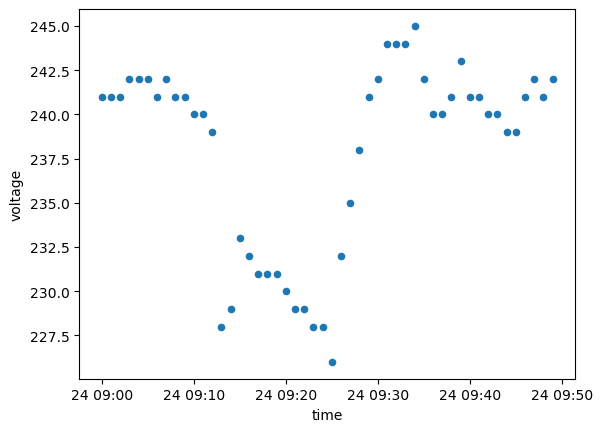

In [20]:
sample_df[0:50].plot(kind='scatter', x='time', y='voltage')

We can see that while the overall trend is linear, at the two or three minute level, the data tends to take an almost stepwise format, staying at a value for one or two minutes before advancing to the next one.  
So, for my first pass, I'll be looking to perform some form of nearest-value fill, just filling either end of a missing range with either it's beginning or end value.  
Please note that I would only apply this form of interpolation to short quantities of missing information, one to three minutes, not large sequences.

In [26]:
def interpolate(begin_range, end_range, begin_value, end_value, mode='nearfill'):
    # begin_range and end_range are both included in the original series
    # the output will be a dataframe including both begin_range and end_range, as well as the filled values in between
    times = [begin_range]
    voltages = [begin_value]
    difference = round((end_range - begin_range).seconds / 60)
    if mode == 'nearfill':
        for i in range(1, difference):
            curr_time = begin_range + timedelta(minutes=i)
            times.append(curr_time)
            if i <= int(difference / 2):
                voltages.append(begin_value)
            else:
                voltages.append(end_value)
        times.append(end_range)
        voltages.append(end_value)

    output_df = pd.DataFrame({'time': times, 'voltage': voltages})
    return output_df

Now we can begin looping through all of the uniform data points, saving all of these relevant datasets.

In [51]:
station_files = os.listdir(uniform_dir)
num_stations = len(station_files)
for index, file in enumerate(station_files):
    print(f'Station {index + 1}/{num_stations}: {file}')

    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])
    time_difference = station_df['time'].diff()
    print(time_difference.apply(lambda x : x.total_seconds()).value_counts())

Station 1/536: station_1.csv
time
60.0         225039
82860.0           4
342060.0          1
313260.0          1
165660.0          1
183660.0          1
3891660.0         1
3733260.0         1
126060.0          1
50460.0           1
136860.0          1
7260.0            1
1065660.0         1
489660.0          1
1980060.0         1
169260.0          1
2696460.0         1
237660.0          1
Name: count, dtype: int64
Station 2/536: station_10.csv
time
60.0         117883
3660.0            3
169260.0          2
284460.0          1
39660.0           1
1465260.0         1
410460.0          1
291660.0          1
14460.0           1
511260.0          1
147660.0          1
248460.0          1
82860.0           1
61260.0           1
Name: count, dtype: int64
Station 3/536: station_100.csv
time
60.0          47469
10860.0          12
32460.0          10
36060.0           8
21660.0           4
14460.0           3
7260.0            3
18060.0           2
28860.0           2
1962060.0         1
864

KeyboardInterrupt: 

It looks like the shorter gaps in time largely don't exist, so we will be ditching interpolation, as we don't have an effective way to accurately fill the typical gaps of an hour or more.

Next we can make the aggregate hourly and daily statistics.  
The aggregate statistic for hourly is the percentage duration of outage in the hour, and for daily, we will both do gross duration, as well as a measurement of outage frequency (discrete events) and average outage duration.

In [36]:
hourly_dir = "../india_processing/india_hourly"

In [37]:
# Loop through, getting to the next whole hour. If the position 60 minutes from it is not the next whole hour, we know that data is incomplete.
station_files = os.listdir(uniform_dir)
num_stations = len(station_files)
for index, file in enumerate(station_files):
    print(f'Station {index + 1}/{num_stations}: {file}')
    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])

    hours = []
    pct_blackout = []
    index = 0
    previous_hour = None
    while index + 60 < station_df.shape[0]:
        if previous_hour is None:
            if station_df['time'][index].minute == 0 and station_df['time'][index].second == 0:
                previous_hour = station_df['time'][index]
        else:
            # If the hour is complete, we take the percentage of that portion of the dataset that is 0 voltage, and save that with the datetime of the
            # beginning of the one hour period
            next_hour = previous_hour + timedelta(hours = 1, minutes = 0, seconds = 0)
            if station_df['time'][index + 60] == next_hour:
                hours.append(previous_hour)
                pct = station_df['voltage'][index:index+60].value_counts().get(0, 0) / 60
                pct_blackout.append(pct)
                index = index + 60
                previous_hour = next_hour
            else:
                # We can backtrack until we hit the next whole hour or before, then do the sixty minutes test again
                while station_df['time'][index] >= next_hour:
                    print(f'{station_df["time"][index]}, {next_hour}')
                    if station_df['time'][index] == next_hour:
                        previous_hour = next_hour
                        break
                    else:
                        index -= 1 
                if station_df['time'][index] < next_hour:
                    while index < station_df.shape[0]:
                        curr_time = station_df['time'][index]
                        if curr_time.minute == 0 and curr_time.second == 0 and curr_time > previous_hour:
                            previous_hour = curr_time
                            break
                        else:
                            index += 1

    id = file.split('_')[1].split('.')[0]
    hourly_df = pd.DataFrame({'hour': hours, 'pct_blackout': pct_blackout})
    hourly_df.to_csv(os.path.join(hourly_dir, f'hourly_station_{id}.csv'), index=False)

Station 1/536: station_1.csv
Station 2/536: station_10.csv
Station 3/536: station_100.csv
Station 4/536: station_101.csv
Station 5/536: station_102.csv
Station 6/536: station_103.csv
Station 7/536: station_104.csv
Station 8/536: station_105.csv
Station 9/536: station_106.csv
Station 10/536: station_107.csv
Station 11/536: station_108.csv
Station 12/536: station_109.csv
Station 13/536: station_11.csv
Station 14/536: station_110.csv
Station 15/536: station_111.csv
Station 16/536: station_112.csv
Station 17/536: station_113.csv
Station 18/536: station_115.csv
Station 19/536: station_116.csv
Station 20/536: station_117.csv
Station 21/536: station_118.csv
Station 22/536: station_119.csv
Station 23/536: station_12.csv
Station 24/536: station_120.csv
Station 25/536: station_121.csv
Station 26/536: station_122.csv
Station 27/536: station_123.csv
Station 28/536: station_124.csv
Station 29/536: station_125.csv
Station 30/536: station_127.csv
Station 31/536: station_128.csv
Station 32/536: statio

Next we can acquire the complete days and loop through to get the outages, which will be split along day boundaries to make the calculation of the aggregate measures simpler, as well as the gross duration.

In [38]:
daily_dir = "../india_processing/india_daily"
outages_dir = "../india_processing/india_outages"
agg_outages_dir = "../india_processing/india_daily_aggregate_outages"

In [39]:
# Loop through, getting to the next whole hour. If the position 60 minutes from it is not the next whole hour, we know that data is incomplete.
station_files = os.listdir(uniform_dir)
num_stations = len(station_files)
for index, file in enumerate(station_files):
    print(f'Station {index + 1}/{num_stations}: {file}')
    station_df = pd.read_csv(os.path.join(uniform_dir, file), header=0, index_col=False, parse_dates=['time'])

    # Lists later converted into daily gross outage duration dataframe
    days = []
    pct_blackout = []

    # Lists later converted into per station outages dataframe
    outage_starts = []
    outage_ends = []
    outage_durations = []

    # Lists later converted into per station daily aggregate outage dataframe
    agg_outage_days = []
    avg_outage_durations = []
    outage_frequencies = []
    index = 0
    previous_day = None
    while index + 1439 < station_df.shape[0]:
        if previous_day is None:
            if station_df['time'][index].hour == 0 and station_df['time'][index].minute == 0 and station_df['time'][index].second == 0:
                previous_day = station_df['time'][index]
            else:
                index += 1
        else:
            # If the day is complete, we take the percentage of that portion of the dataset that is 0 voltage, and save that with the datetime of the
            # beginning of the one hour period
            end_of_hour = previous_day + timedelta(hours = 23, minutes = 59)
            next_day = end_of_hour + timedelta(minutes = 1)
            if station_df['time'][index + 1439] == end_of_hour:
                days.append(previous_day)
                pct = station_df['voltage'][index:index+1440].value_counts().get(0, 0) / 1440
                pct_blackout.append(pct)

                # In addition to getting the gross duration, we also loop through to get the outages for the station for this complete day
                outage_starts_today = []
                outage_ends_today = []
                outage_durations_today = []
                outage_start = None
                outage_continuing = False
                for i in range(index, index + 1440):
                    if station_df['voltage'][i] == 0:
                        if not outage_continuing: # outage start
                            outage_start = station_df['time'][i]
                            outage_continuing = True
                    else:
                        if outage_continuing: # outage end
                            outage_end = station_df['time'][i]
                            duration = outage_end - outage_start
                            duration = duration.total_seconds() / 60

                            outage_starts_today.append(outage_start)
                            outage_ends_today.append(outage_end)
                            outage_durations_today.append(duration)

                            outage_continuing = False
                            outage_start = None

                # Append to overall station outages lists
                outage_starts.extend(outage_starts_today)
                outage_ends.extend(outage_ends_today)
                outage_durations.extend(outage_durations_today)
                
                # Compute daily aggregate outage statistics
                if len(outage_durations_today):
                    avg_duration = np.mean(outage_durations_today)
                else:
                    avg_duration = 0
                freq = len(outage_starts_today)

                agg_outage_days.append(previous_day)
                avg_outage_durations.append(avg_duration)
                outage_frequencies.append(freq)
                
                index = index + 1440
                previous_day = None # allow the script to reacquire the next day
            else:
                # We can backtrack until we hit the next whole hour or before, then do the 1439 minutes test again
                while station_df['time'][index] >= next_day:
                    if station_df['time'][index] == next_day:
                        previous_day = next_day
                        break
                    else:
                        index -= 1 
                if station_df['time'][index] < next_day:
                    while index < station_df.shape[0]:
                        curr_time = station_df['time'][index]
                        if curr_time.hour == 0 and curr_time.minute == 0 and curr_time.second == 0 and curr_time > previous_day:
                            previous_day = curr_time
                            break
                        else:
                            index += 1

    id = file.split('_')[1].split('.')[0]
    daily_df = pd.DataFrame({'date': days, 'pct_blackout': pct_blackout})
    daily_df.to_csv(os.path.join(daily_dir, f'daily_station_duration_{id}.csv'), index=False)

    outages_df = pd.DataFrame({'outage_start': outage_starts, 'outage_end': outage_ends, 'duration': outage_durations})
    outages_df.to_csv(os.path.join(outages_dir, f'outages_station_{id}.csv'), index=False)

    agg_outages_df = pd.DataFrame({'date': agg_outage_days, 'avg_duration': avg_outage_durations, 'freq': outage_frequencies})
    agg_outages_df.to_csv(os.path.join(agg_outages_dir, f'agg_outages_station_{id}.csv'), index=False)

Station 1/536: station_1.csv
Station 2/536: station_10.csv
Station 3/536: station_100.csv
Station 4/536: station_101.csv
Station 5/536: station_102.csv
Station 6/536: station_103.csv
Station 7/536: station_104.csv
Station 8/536: station_105.csv
Station 9/536: station_106.csv
Station 10/536: station_107.csv
Station 11/536: station_108.csv
Station 12/536: station_109.csv
Station 13/536: station_11.csv
Station 14/536: station_110.csv
Station 15/536: station_111.csv
Station 16/536: station_112.csv
Station 17/536: station_113.csv
Station 18/536: station_115.csv
Station 19/536: station_116.csv
Station 20/536: station_117.csv
Station 21/536: station_118.csv
Station 22/536: station_119.csv
Station 23/536: station_12.csv
Station 24/536: station_120.csv
Station 25/536: station_121.csv
Station 26/536: station_122.csv
Station 27/536: station_123.csv
Station 28/536: station_124.csv
Station 29/536: station_125.csv
Station 30/536: station_127.csv
Station 31/536: station_128.csv
Station 32/536: statio

# Extracting Weather Information for Relevant Stations from NetCDF4
Voltage station coordinates determined:
- Google Maps for neighborhood names
- Referenced the existing stations in the same neighborhood for same data
- ERA5 grid


# Converting Hourly Weather Data into Daily Aggregate Data
The two main operations that we have to do for the extraction of the hourly data is to take the difference between the current and previous total precpitations, as tp is an accumulation variable, meaning it is strictly increasing throughout the day and represents the total precipitation up to that point in the day.

For the daily aggregate data, we simply take the average over a day of most of the weather variables, and for the tp accumulation variable, we take the value that is present at 12:00 AM the next day, which is confusingly the total accumulated precipitation for the previous day.

In addition, we calculate a cluster of other weather variables, such as relative humidity.

In [84]:
def calculate_saturation_pressure_water(t2m):
    a1 = 611.21
    a3 = 17.502
    a4 = 32.19
    T0 = 273.16
    return a1 * t2m.apply(lambda x: math.exp(a3 * (x - T0) / (x - a4)))

def calculate_saturation_pressure_ice(t2m):
    a1 = 611.21
    a3 = 22.587
    a4 = -0.7
    T0 = 273.16
    return a1 * t2m.apply(lambda x: math.exp(a3 * (x - T0) / (x - a4)))

def calculate_mixed_phase_parameter(t2m):
    Tice = 250.16
    T0 = 273.16
    return t2m.apply(lambda x: 0 if x <= Tice else (1 if x >= T0 else ((x - Tice) / (T0 - Tice)) ** 2))

def calculate_specific_humidity(t2m, p):
    Rdry = 287.05  # Specific gas constant for dry air in J/(kg·K)
    Rvap = 461.5   # Specific gas constant for water vapor in J/(kg·K)
    esat = calculate_saturation_pressure_water(t2m)
    q_sat = ((Rvap / Rdry) * esat) / (p - (1 - Rvap / Rdry) * esat)
    return q_sat

def calculate_relative_humidity(t2m, p, q):
    epsilon = 0.621981
    esat_w = calculate_saturation_pressure_water(t2m)
    esat_i = calculate_saturation_pressure_ice(t2m)
    alpha = calculate_mixed_phase_parameter(t2m)
    esat = alpha * esat_w + (1 - alpha) * esat_i
    e = (p * q ** (1 / epsilon)) / (esat * (1 + q * (1 / epsilon - 1)))
    RH = 100 * e
    return RH

In [97]:
# Define the folder containing the hourly weather variables CSV files
raw_weather_dir = "E:\Georgia Institute of Technology\He, Yiyi - 01_data\Final_version\weather_india"
daily_dir = "../india_processing/india_daily"
hourly_dir = "../india_processing/india_hourly"

pd.set_option('mode.chained_assignment', None)

# Create a sub-folder called 'daily'
daily_weather_dir = os.path.join(raw_weather_dir, 'daily_new')
hourly_weather_dir = os.path.join(raw_weather_dir, 'hourly')
os.makedirs(raw_weather_dir, exist_ok=True)
os.makedirs(daily_weather_dir, exist_ok=True)
os.makedirs(hourly_weather_dir, exist_ok=True)

# Get a list of all CSV files in the folder
files = [file for file in os.listdir(daily_dir) if file.endswith('.csv')]

# Iterate through each CSV file
for file in tqdm(files):
    station_id = file.split('_')[-1].split('.')[0]
    padded_id = '0' * (3 - len(str(station_id))) + str(station_id)
    # Read the CSV file into a DataFrame
    voltage_df = pd.read_csv(os.path.join(daily_dir, file), index_col=False, parse_dates=['date'])
    hourly_df = pd.read_csv(os.path.join(hourly_dir, f'hourly_station_{station_id}.csv'), index_col=False, parse_dates=['hour'])
    try:
        weather_df = pd.read_csv(os.path.join(raw_weather_dir, f'station_{padded_id}_data.csv'), index_col=False, parse_dates=['datetime'])
    except:
        print(station_id)
        continue

    ###### Calculation of the Hourly and Daily Total Precipitation #######
    # Convert the total precipitation to mm
    weather_df['tp'] = weather_df['tp'] * 1000

    # Calculate total precipitation within an hour as the difference between the current hour and the previous, with the exception of 01:00, which would
    # always be 0
    weather_tp_time = weather_df[['datetime', 'tp']]
    weather_tp_time = weather_tp_time.set_index('datetime')
    tp_time_diff = weather_tp_time - weather_tp_time.shift(1)
    hour_ones = tp_time_diff.index.time == datetime.time(datetime(year=1900, month=1, day=1, hour=1))
    tp_time_diff.loc[hour_ones] = weather_tp_time.loc[hour_ones] # For 1:00 AM take the value from the original dataset, as it is the start of a new day
    weather_df['tp_h'] = tp_time_diff['tp'].values

    # Extract 'tp' value for 12:00 AM of the next day, which is when the accumulation variable is finished
    last_hour_tp = weather_df[weather_df['datetime'].dt.hour == 0].groupby(weather_df['datetime'].dt.date)['tp'].last()
    last_hour_tp = last_hour_tp.shift(-1)

    ###### Hourly Aggregate Calcs #########

    # Get only the dates that are required for the aggregation and windowing operations necessary, so, only the hours that are in the voltage dataset
    # If the hours start at a time that 
    # additionally, in the case where the last hour in the dataframe is 11:00 PM, we want to include the next 12:00 AM so we have the daily acumulated
    # precipitation
    present_hours = hourly_df['hour']
    desired_hours = [hourly_df['hour']]
    if present_hours.iloc[-1].hour == 23:
        desired_hours.append(pd.Series([present_hours.iloc[-1] + timedelta(hours=1)]))
    if not present_hours.iloc[0].hour == 1:
        desired_hours.insert(0, pd.Series([present_hours.iloc[0] - timedelta(hours=1)]))

    desired_hours = pd.concat(desired_hours)

    filtered_weather_df = weather_df.loc[weather_df['datetime'].isin(desired_hours)]

    # Calculate wind speed
    u_sq = filtered_weather_df['u10'] ** 2
    v_sq = filtered_weather_df['v10'] ** 2
    
    # Calculate daily average wind speed
    filtered_weather_df['wind'] = np.sqrt(u_sq + v_sq)
    
    # Convert T to t2m (assuming T represents air temperature in Celsius)
    filtered_weather_df.rename(columns={'t2m' : 't2m_k'}, inplace=True)
    
    # Calculate specific humidity for each row
    filtered_weather_df['sh'] = calculate_specific_humidity(filtered_weather_df['t2m_k'], filtered_weather_df['sp'])
    
    # Calculate relative humidity for each row
    filtered_weather_df['rh'] = calculate_relative_humidity(filtered_weather_df['t2m_k'], filtered_weather_df['sp'], filtered_weather_df['sh'])
    
    # Convert the total precipitation to mm
    filtered_weather_df['tp'] = filtered_weather_df['tp'] * 1000

    hourly_weather_df = filtered_weather_df[['datetime', 't2m_k', 'd2m', 'wind', 'tp_h', 'e', 'sp', 'sh', 'rh']]
    hourly_weather_df.rename(columns={'tp_h':'tp'}, inplace=True)
    hourly_weather_df.dropna(inplace=True)
    hourly_weather_df.to_csv(os.path.join(hourly_weather_dir, f'station_{padded_id}_data_hourly.csv'), index=False)
    
    ###### Daily Aggregate Calcs #########
    
    # Aggregate daily average for several variables, leaving out total precipitation, as it is an accumulating value
    daily_weather_df = filtered_weather_df.groupby(filtered_weather_df['datetime'].dt.date)[['t2m_k', 'd2m', 'sp', 'wind', 'sh', 'rh', 'e']].mean()
    
    # Merge daily average, wind speed, and last hour tp columns
    daily_weather_df = daily_weather_df.join(last_hour_tp, rsuffix='_last_hour')
    daily_weather_df.insert(0, 'datetime', pd.to_datetime(daily_weather_df.index))
    daily_weather_df.reset_index(drop=True, inplace=True)

    daily_data_df = daily_weather_df.loc[daily_weather_df['datetime'].isin(voltage_df['date'])]    
    daily_data_df.rename(columns={'datetime': 'date'}, inplace=True)
    
    # Save the aggregated daily weather variables to a new CSV file in the 'daily' sub-folder
    daily_data_df.dropna(inplace=True)
    daily_data_df.to_csv(os.path.join(daily_weather_dir, f'station_{padded_id}_data_daily.csv'), index=False)

 30%|███       | 161/536 [00:58<02:10,  2.87it/s]

25


 32%|███▏      | 172/536 [01:03<02:06,  2.88it/s]

26


 34%|███▍      | 184/536 [01:06<01:53,  3.10it/s]

270
271
272


 40%|███▉      | 214/536 [01:16<01:53,  2.84it/s]

3


100%|██████████| 536/536 [03:27<00:00,  2.58it/s]


# Joining Climate and Voltage Data
After we have successfully gotten both the aggregate voltage data and climate data, we can quickly merge the datasets, first into station-wise datasets, and then into a mega panel data dataset, which is labelled with station_id, as well as the daily aggregate factors, daily gross duration, and daily climate.

### Daily Data

In [98]:
daily_climate_dir = "E:\Georgia Institute of Technology\He, Yiyi - 01_data\Final_version\weather_india\daily_new"
panel_dir = '../india_panel/'
station_panel_dir = '../india_panel/by_station'
hourly_station_panel_dir = '../india_panel/by_station_hourly'

In [115]:
station_panel_daily_dfs = []
locations_renamed = locations.rename({'station_name': 'location'}, axis=1)
for station_id in locations['station_id']:
    if station_id in [25, 26, 270, 271, 272, 3, 497, 572]: # so jank, please fix/document
        continue
    
    padded_id = '0' * (3 - len(str(station_id))) + str(station_id)
    daily_weather_df = pd.read_csv(os.path.join(daily_climate_dir, f'station_{padded_id}_data_daily.csv'), index_col=False, parse_dates=['date'])
    daily_df = pd.read_csv(os.path.join(daily_dir, f'daily_station_duration_{station_id}.csv'), index_col=False, parse_dates=['date'])
    daily_agg_df = pd.read_csv(os.path.join(agg_outages_dir, f'agg_outages_station_{station_id}.csv'), index_col=False, parse_dates=['date'])

    if daily_df.shape[0] < 15:
        print(station_id)
        station_location_index = locations_renamed['station_id'] == station_id
        print(locations_renamed['location'][station_location_index].values[0])
        continue

    station_panel_df = daily_df.merge(daily_agg_df, on='date', ).merge(daily_weather_df, on='date')
    station_panel_df.to_csv(os.path.join(station_panel_dir, f'station_panel_{station_id}.csv'), index=False)
    station_location_index = locations_renamed['station_id'] == station_id
    station_panel_df['station_id'] = locations_renamed['station_id'][station_location_index].values[0]
    station_panel_df['location'] = locations_renamed['location'][station_location_index].values[0]
    station_panel_df['district'] = locations_renamed['district'][station_location_index].values[0]
    station_panel_df['state'] = locations_renamed['state'][station_location_index].values[0]
    station_panel_df['lat'] = locations_renamed['lat'][station_location_index].values[0]
    station_panel_df['lon'] = locations_renamed['lon'][station_location_index].values[0]
    station_panel_daily_dfs.append(station_panel_df)
    
all_stations_daily_panel_df = pd.concat(station_panel_daily_dfs)

58
Barra 2
103
Chichaliya
130
Dhangar Toli Chatra
134
Dhawatand
386
Rasuliya Hoshangabad
405
Salgaon
518
Kharsoma (N) Sultanpur
563
Netarhat


C:\Users\nytig\AppData\Local\Temp\ipykernel_6988\2556627126.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stations_daily_panel_df = pd.concat(station_panel_daily_dfs)


In [100]:
today = datetime.now().strftime(format="%m%d%y")
all_stations_daily_panel_df.to_csv(os.path.join(panel_dir, f'panel_daily_{today}.csv'), index=False)
print(f'Total Station-Days: {all_stations_daily_panel_df.shape[0]}')

### Hourly Data

In [107]:
station_panel_hourly_dfs = []
locations_renamed = locations.rename({'station_name': 'location'}, axis=1)
for station_id in locations['station_id']:
    if station_id in [25, 26, 270, 271, 272, 3, 497, 572]: # so jank, please fix/document
        continue
    
    padded_id = '0' * (3 - len(str(station_id))) + str(station_id)
    hourly_weather_df = pd.read_csv(os.path.join(hourly_weather_dir, f'station_{padded_id}_data_hourly.csv'), index_col=False, parse_dates=['datetime'])
    hourly_df = pd.read_csv(os.path.join(hourly_dir, f'hourly_station_{station_id}.csv'), index_col=False, parse_dates=['hour'])

    if hourly_df.shape[0] < 15:
        print(station_id)
        continue

    station_panel_df = hourly_df.merge(hourly_weather_df, left_on='hour', right_on='datetime')
    station_panel_df.to_csv(os.path.join(hourly_station_panel_dir, f'station_hourly_panel_{station_id}.csv'), index=False)
    station_location_index = locations_renamed['station_id'] == station_id
    station_panel_df['station_id'] = locations_renamed['station_id'][station_location_index].values[0]
    station_panel_df['location'] = locations_renamed['location'][station_location_index].values[0]
    station_panel_df['district'] = locations_renamed['district'][station_location_index].values[0]
    station_panel_df['state'] = locations_renamed['state'][station_location_index].values[0]
    station_panel_df['lat'] = locations_renamed['lat'][station_location_index].values[0]
    station_panel_df['lon'] = locations_renamed['lon'][station_location_index].values[0]
    station_panel_hourly_dfs.append(station_panel_df)
    
all_stations_hourly_panel_df = pd.concat(station_panel_hourly_dfs)
all_stations_hourly_panel_df.drop('hour', axis=1, inplace=True)
all_stations_hourly_panel_df = all_stations_hourly_panel_df[['datetime'] + [col for col in all_stations_hourly_panel_df.columns if col != 'datetime']]

C:\Users\nytig\AppData\Local\Temp\ipykernel_6988\5468026.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stations_hourly_panel_df = pd.concat(station_panel_hourly_dfs)


In [108]:
today = datetime.now().strftime(format="%m%d%y")
all_stations_hourly_panel_df.to_csv(os.path.join(panel_dir, f'panel_hourly_{today}.csv'), index=False)
print(f'Total Station-Hours: {all_stations_hourly_panel_df.shape[0]}')

## Cleanup
Some data anamolies were located during analysis and need to be cleaned up.
The first is to ensure that the times in the harvard dataverse dataset are strictly increasing, and if not, remove them entirely.
This can be done manually if the number of cases where this strange outlier is present is small, as we were under the impression that the dataverse datasets were complete.

We discovered that the entire 2019July_Dec sheet is invalid, as all of the hour values is 0, so that entire sheet can be discarded.

Additionally we have to check if any of the station rows are duplicate. In the case where they are duplicate and the voltage values are identical, we can simply delete one entry.
However, when there are two conflicting values, we simply have to delete both.

In [24]:
dataverse_dir = "../india_dataverse/"

for file in os.listdir(dataverse_dir):
    print(file)
    hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)

    # Remove the weird excel export #VALUE! artifacts
    hd_df.replace('#VALUE!', pd.NA, inplace=True)
    hd_df.dropna(inplace=True)
    hd_df.iloc[:, -60:] = hd_df.iloc[:, -60:].apply(pd.to_numeric)

    # Merge the date and hour columns to create a pd datetime
    if '/' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%m/%d/%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    elif '-' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%d-%m-%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    else:
        print('Invalid date format')
        break
        
    hd_df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Derive the uniform station_id from the station names
    hd_df.rename(columns={'Location name': 'station_name'}, inplace=True)
    
    total_duplicates = {}
    time_duplicates = {}
    stations = hd_df.station_name.unique()
    for station in stations:
        station_df = hd_df[hd_df['station_name'] == station]
        last = datetime(year=2001, month=1, day=1)
        last_index = 0
        for index in station_df.index:
            time = station_df.loc[index, 'time']
            if time <= last:
                if station_df.loc[index, :].equals(station_df.loc[last_index, :]):
                    total_duplicates[station] = total_duplicates.get(station, 0) + 1
                    print(f'Total_duplicates at: {last_index}, {index}')
                elif time == last:
                    time_duplicates[station] = time_duplicates.get(station, 0) + 1
                    print(f'Time_duplicates at: {last_index}, {index}')
                    
            last = station_df.loc[index, 'time']
            last_index = index

ESMI_harvard_dataverse_voltage_data_2014.csv
ESMI_harvard_dataverse_voltage_data_2015.csv
ESMI_harvard_dataverse_voltage_data_2016 Jan-Jun.csv
ESMI_harvard_dataverse_voltage_data_2016_Jul_Dec.csv
ESMI_harvard_dataverse_voltage_data_2017_Jan_Apr.csv
ESMI_harvard_dataverse_voltage_data_2017_May_Aug.csv
ESMI_harvard_dataverse_voltage_data_2017_Sep_Dec.csv
ESMI_harvard_dataverse_voltage_data_2018_Jan_May.csv
ESMI_harvard_dataverse_voltage_data_2018_Jun-Aug.csv
ESMI_harvard_dataverse_voltage_data_2018_Sep_Dec.csv


In [13]:
print(total_duplicates)
print(time_duplicates)

{'Kanheri Sarap [Offline]': 2, 'Jan Path- Bhubaneswar [Offline]': 2, 'Brahmavar': 4, 'Bhajanpura- Delhi [Offline]': 18, 'Sadar- Nagpur': 2, 'Gondur- Dhule': 2, 'Baijnathpur-Saharsa': 52, 'Jori-Saharsa [Offline]': 1, 'Sadashiv Nagar- Belgaum': 2, 'Bhadupur Sidhauli': 18, 'Arjun Nagar-Ghaziabad [Offline]': 2, 'Gogal Madgaon- Goa [Offline]': 3, 'Cuncolim- Goa': 10, 'Bhattha Mehmoodabad [Offline]': 31, 'Sector 70- Mohali': 8, 'Kakatiya Nagar- Hyderabad  [Offline]': 148, 'Kondhanpur': 3, 'Kalpataru Nagar - Nashik': 8, 'Netaji Nagar- Chennai [Offline]': 3, 'Prithvi Avenue- Chennai': 12, 'Samta Colony _Raipur': 7, 'Mavli- Udaipur [Offline]': 37, 'Civil Lines - Jaipur [Offline]': 7, 'Karsood- Palghar [Offline]': 10, 'Bamunimaidan Guwahati [Offline]': 4, 'Sumerpur-Chamoli [Offline]': 1, 'Kaulagarh Dehradun [Offline]': 1, 'Tarun Nagar Guwahati': 4, 'Capital Electrical Subdivision Guwahati': 1, 'Sri Ram Rang Pura-Bellary': 3, 'Pathauli-Agra [Offline]': 3, 'Khed Ratnagiri': 1, 'Bangi Kunta Raichur

We can see that two stations of special concern are Bodireddypally-Prakasam and Kanheri Sarap, as they have a large number of duplicate rows that are not duplicate in value, and thus have to be deleted. I choose to discard these two stations entirely, reasoning that their data quality is simply too low.

## Removing Erroneous Data
In order to untangle the existing dataverse data from our uniform dataset, we have to ensure that the previous dataverse datasheets actually contain data only from before January of 2019, in order to enforce a hard cutoff on all of the non-scraped voltage stations.

Then we can add the dataverse data back in, removing the problem stations, as well as any voltage values which are greater than 400, the range which seems to be typical of the other datasets.

In [25]:
for file in os.listdir(dataverse_dir)[:-1]:
    print(file)
    hd_df = pd.read_csv(os.path.join(dataverse_dir, file), header=0)

    # Remove the weird excel export #VALUE! artifacts
    hd_df.replace('#VALUE!', pd.NA, inplace=True)
    hd_df.dropna(inplace=True)
    hd_df.iloc[:, -60:] = hd_df.iloc[:, -60:].apply(pd.to_numeric)

    # Merge the date and hour columns to create a pd datetime
    if '/' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%m/%d/%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    elif '-' in hd_df['Date'][0]:
        hd_df.insert(loc=1, column='time', value=(pd.to_datetime(hd_df['Date'], format='%d-%m-%Y') + pd.to_timedelta(hd_df['Hour'], unit='h')))
    else:
        print('Invalid date format')
        break
        
    hd_df.drop(['Date', 'Hour'], axis=1, inplace=True)
    
    # Derive the uniform station_id from the station names
    hd_df.rename(columns={'Location name': 'station_name'}, inplace=True)
    
    total_duplicates = {}
    time_duplicates = {}
    thresh = datetime(year=2019, month=1, day=1)
    stations = hd_df.station_name.unique()
    for station in stations:
        station_df = hd_df[hd_df['station_name'] == station]
        for index in station_df.index:
            time = station_df.loc[index, 'time']
            if time >= thresh:
                print(f'{index} {station}, {time}')

ESMI_harvard_dataverse_voltage_data_2014.csv
ESMI_harvard_dataverse_voltage_data_2015.csv
ESMI_harvard_dataverse_voltage_data_2016 Jan-Jun.csv
ESMI_harvard_dataverse_voltage_data_2016_Jul_Dec.csv
ESMI_harvard_dataverse_voltage_data_2017_Jan_Apr.csv
ESMI_harvard_dataverse_voltage_data_2017_May_Aug.csv
ESMI_harvard_dataverse_voltage_data_2017_Sep_Dec.csv
ESMI_harvard_dataverse_voltage_data_2018_Jan_May.csv
ESMI_harvard_dataverse_voltage_data_2018_Jun-Aug.csv
ESMI_harvard_dataverse_voltage_data_2018_Sep_Dec.csv


Now that we have determined it is safe to do so, we can go through all of the stations that come from the dataverse dataset and remove datapoints after 2019.

In [7]:
thresh = datetime(year=2019, month=1, day=1)
for station_id in locations['station_id']:
    if station_id >= 497 and station_id < 529 and not station_id == 504:
        if os.path.exists(os.path.join(uniform_dir, f'station_{station_id}.csv')):
            print(f'Station: {station_id}')
            station_df = pd.read_csv(os.path.join(uniform_dir, f'station_{station_id}.csv'), index_col=False, parse_dates=['time'])
            print(f'{station_df.shape[0]} rows')
            station_df = station_df[station_df['time'] < thresh]
            print(f'{station_df.shape[0]} rows')
            station_df.to_csv(os.path.join(uniform_dir, f'station_{station_id}.csv'), index=False)

Station: 498
2222820 rows
1968180 rows
Station: 499
445980 rows
445980 rows
Station: 500
907860 rows
907860 rows
Station: 501
326220 rows
284340 rows
Station: 502
700260 rows
700260 rows
Station: 503
1070760 rows
1070760 rows
Station: 505
89040 rows
89040 rows
Station: 506
462900 rows
351000 rows
Station: 508
2188800 rows
1681920 rows
Station: 509
973440 rows
484740 rows
Station: 510
225120 rows
225120 rows
Station: 511
483540 rows
171780 rows
Station: 512
465180 rows
152820 rows
Station: 513
444600 rows
155400 rows
Station: 514
467160 rows
139560 rows
Station: 515
475140 rows
149640 rows
Station: 516
478860 rows
172800 rows
Station: 517
471300 rows
167100 rows
Station: 518
316320 rows
8160 rows
Station: 519
440580 rows
137520 rows
Station: 520
419700 rows
175680 rows
Station: 521
605160 rows
175680 rows
Station: 522
434280 rows
175680 rows
Station: 523
447300 rows
171780 rows
Station: 524
473820 rows
155460 rows
Station: 525
148320 rows
148320 rows
Station: 526
520380 rows
175620 rows